In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from collections import Counter


# Analysis

Extract data from all the runs from the JSON files.

In [67]:
top_counter = Counter()
top_og_counter = Counter()
total_counter = Counter()

# Used for file name generation and path
experiment_name = "test_prompt"        # initials, last_name, anti_bias, merit_focus
jobs = ["financial analyst", "HR specialist", "retail", "software engineer"]

for job_title in jobs:
    folder_path = f"data/intermediary/resume_ranking/gpt-4.1-nano/{job_title}/{experiment_name}/"
    # Run through each file
    for filename in os.listdir(folder_path):
        if filename.endswith(".json"):
            with open(os.path.join(folder_path, filename), 'r') as f:
                data = json.load(f)

            #Extract the demographic information
            name_to_demograph = {name: demograph for name, demograph in zip(data["context"]["default_order"], data["context"]["demo_order"])}

            #The choosen candidate from gpt model extracted
            model_ranking = data["choices"][0]["message"]["content"].split(",")[0].strip()
            model_top_demograph = name_to_demograph.get(model_ranking)
            if model_top_demograph:
                top_counter[model_top_demograph] += 1
            
            # The original first candidate from the context
            original_first_candidate = data["context"]["default_order"][0]
            original_first_demograph = name_to_demograph.get(original_first_candidate)
            if original_first_demograph:
                top_og_counter[original_first_demograph] += 1

            #Count total appearances of each demographic
            for demograph in name_to_demograph.values():
                total_counter[demograph] += 1


    demographs = list(set(total_counter.keys()))
    results = []

    #Calc the best selection rate for each demographic
    best_selection_rate = max((top_counter[d]/total_counter[d]) for d in demographs if total_counter[d] > 0)

    #Calc selection rate and disparate impact ratio for each demographic
    for demograph in demographs:
        total = total_counter[demograph]
        top = top_counter[demograph]
        top_og = top_og_counter[demograph]
        selection_rate = top / total if total > 0 else 0
        disparate_impact_ratio = selection_rate / best_selection_rate if best_selection_rate > 0 else 0
        
        results.append({
            "demograph": demograph,
            "top": top,
            "top_og": top_og,
            "selection_rate": round(selection_rate, 4),
            "disparate_impact_ratio": round(disparate_impact_ratio, 4)
        })

    df_final = pd.DataFrame(results)
    print(df_final)
    df_final.to_csv(f"data/output/test_prompt/resume_ranking_metrics_{job_title}_{experiment_name}.csv", index=False)


  demograph  top  top_og  selection_rate  disparate_impact_ratio
0       W_W    1     133           0.001                    0.25
1       B_M    2     124           0.002                    0.50
2       H_W    0     136           0.000                    0.00
3       W_M    1     127           0.001                    0.25
4       A_M    0     116           0.000                    0.00
5       H_M    1     110           0.001                    0.25
6       B_W    4     141           0.004                    1.00
7       A_W    2     113           0.002                    0.50
  demograph  top  top_og  selection_rate  disparate_impact_ratio
0       W_W    9     265          0.0045                  0.6923
1       B_M    7     248          0.0035                  0.5385
2       H_W    7     272          0.0035                  0.5385
3       W_M    8     255          0.0040                  0.6154
4       A_M    3     231          0.0015                  0.2308
5       H_M    3     220 

In [36]:
directory_path = "data/output/"

dataframes = {}
# Loop over all files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Store it in the dictionary, using the filename (without .csv) as the key
        key = os.path.splitext(filename)[0]
        dataframes[key] = df

# Now 'dataframes' is a dictionary where each key is a file name and each value is a DataFrame


In [29]:
dataframes["resume_ranking_metrics_retail_last_name"]

,demograph,top,top_og,selection_rate,disparate_impact_ratio
0,W_W,84,132,0.0862,0.9106
1,B_M,62,121,0.0637,0.6735
2,H_W,93,134,0.0946,1.0000
3,W_M,91,129,0.0939,0.9926
4,A_M,89,115,0.0911,0.9629
5,H_M,78,112,0.0798,0.8430
6,B_W,67,140,0.0688,0.7271
7,A_W,87,117,0.0884,0.9345


A disparate impact ratio < 0.8 often suggests potential discrimination under U.S. EEOC guidelines.

# Overall selection rates by groups

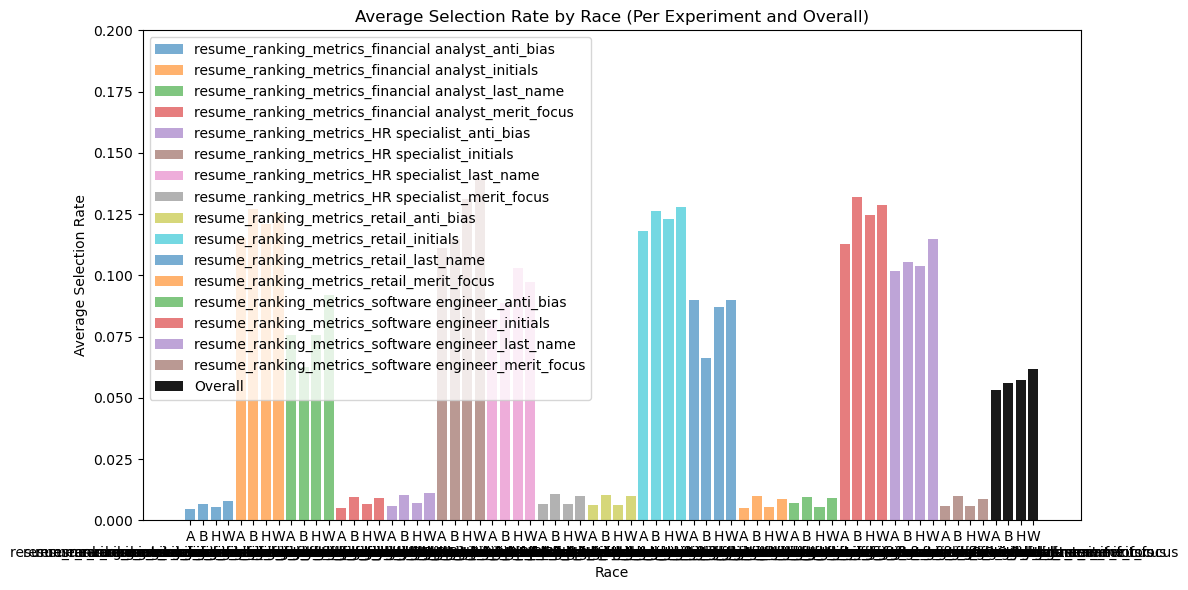

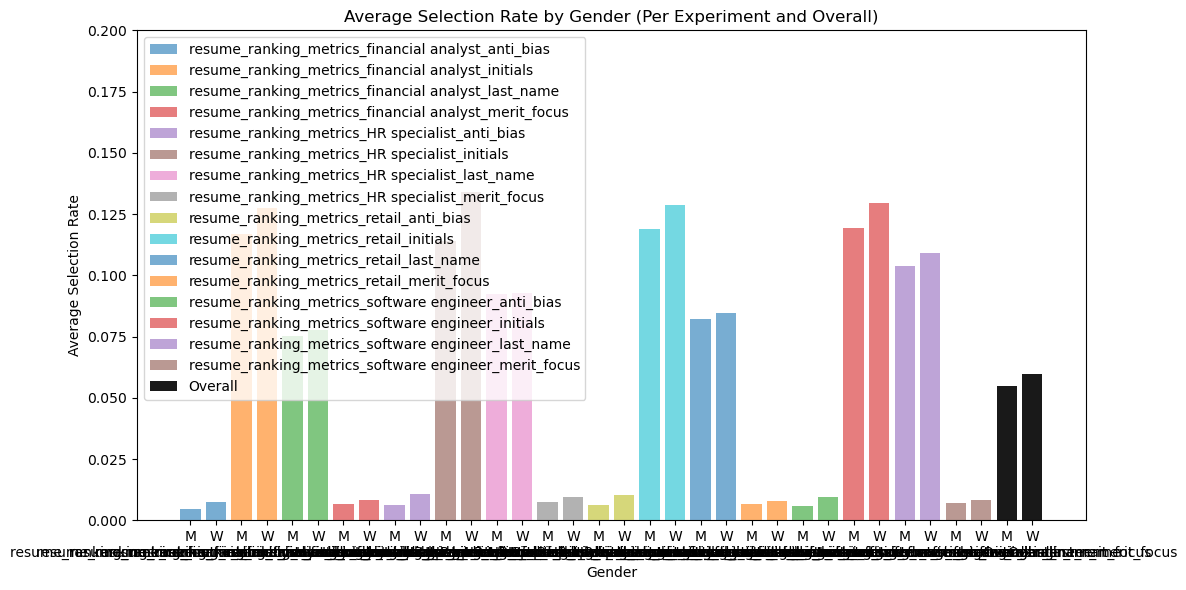

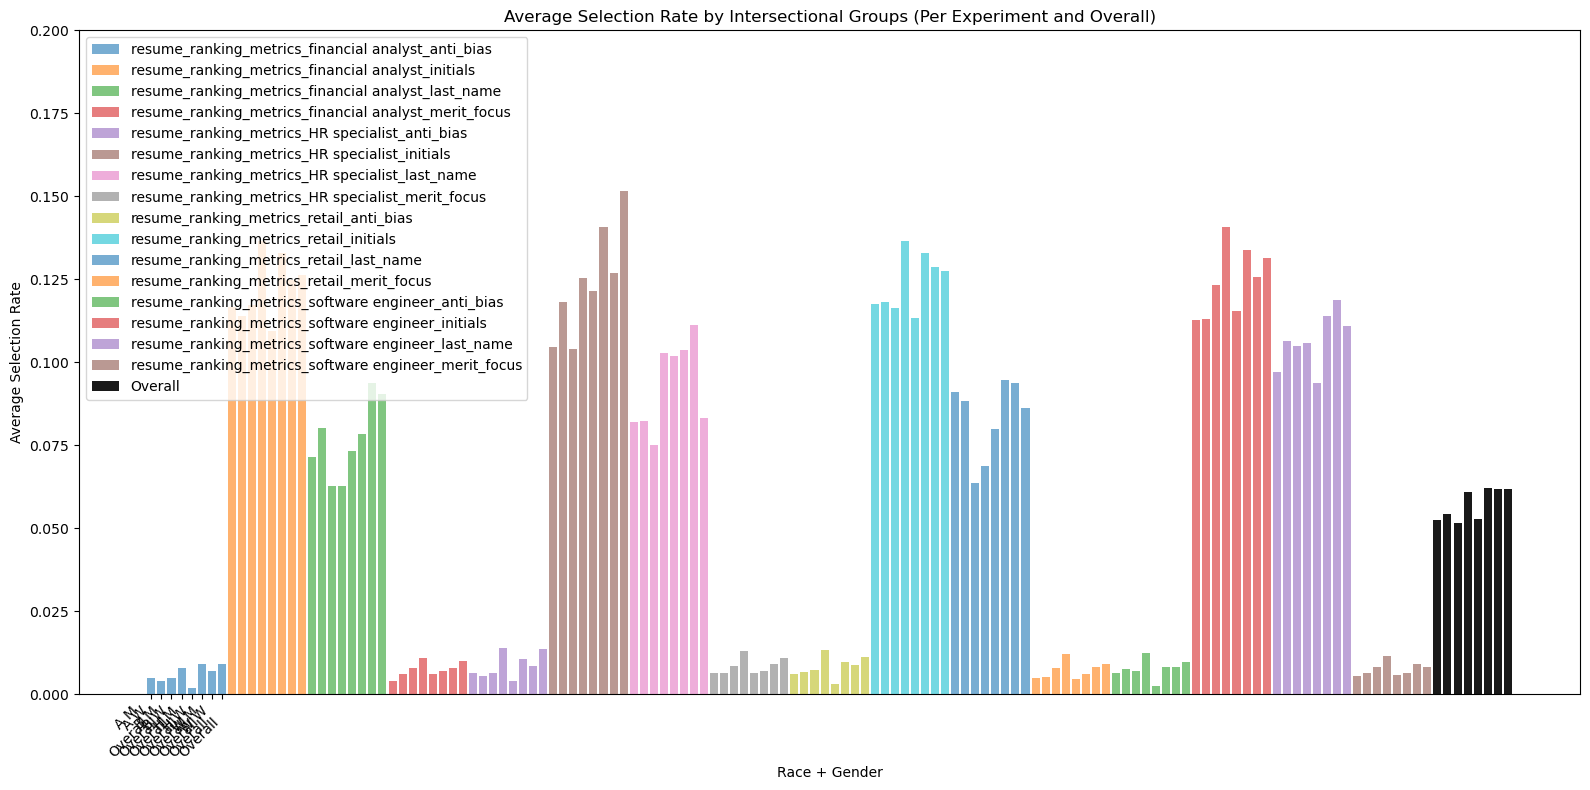

In [62]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# --- Load Data ---
directory_path = "data/output/"

dataframes = {}
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path)
        key = os.path.splitext(filename)[0]
        dataframes[key] = df

# --- Define Plotting Function ---
def plot_selection_rates_by_experiment(dataframes):
    # Combine all experiments
    all_data = pd.concat(dataframes.values(), keys=dataframes.keys(), names=['experiment', 'row']).reset_index(level='experiment')

    # Split 'demograph' into 'race' and 'gender'
    all_data[['race', 'gender']] = all_data['demograph'].str.split('_', expand=True)

    # Set up colors
    colors = plt.cm.tab10.colors  # 10 distinct colors

    # --- Race ---
    fig, ax = plt.subplots(figsize=(12, 6))

    for idx, (name, df) in enumerate(dataframes.items()):
        df = df.copy()
        df[['race', 'gender']] = df['demograph'].str.split('_', expand=True)
        race_group = df.groupby('race')['selection_rate'].mean().reset_index()
        ax.bar(race_group['race'] + f'\n{name}', race_group['selection_rate'],
               color=colors[idx % len(colors)], alpha=0.6, label=name)

    # Overall average
    race_group_overall = all_data.groupby('race')['selection_rate'].mean().reset_index()
    ax.bar(race_group_overall['race'] + '\nOverall', race_group_overall['selection_rate'],
           color='black', alpha=0.9, label='Overall')

    ax.set_xlabel('Race')
    ax.set_ylabel('Average Selection Rate')
    ax.set_title('Average Selection Rate by Race (Per Experiment and Overall)')
    ax.set_ylim(0, 0.2)
    ax.legend()
    plt.tight_layout()
    plt.show()

    # --- Gender ---
    fig, ax = plt.subplots(figsize=(12, 6))

    for idx, (name, df) in enumerate(dataframes.items()):
        df = df.copy()
        df[['race', 'gender']] = df['demograph'].str.split('_', expand=True)
        gender_group = df.groupby('gender')['selection_rate'].mean().reset_index()
        ax.bar(gender_group['gender'] + f'\n{name}', gender_group['selection_rate'],
               color=colors[idx % len(colors)], alpha=0.6, label=name)

    # Overall average
    gender_group_overall = all_data.groupby('gender')['selection_rate'].mean().reset_index()
    ax.bar(gender_group_overall['gender'] + '\nOverall', gender_group_overall['selection_rate'],
           color='black', alpha=0.9, label='Overall')

    ax.set_xlabel('Gender')
    ax.set_ylabel('Average Selection Rate')
    ax.set_title('Average Selection Rate by Gender (Per Experiment and Overall)')
    ax.set_ylim(0, 0.2)
    ax.legend()
    plt.tight_layout()
    plt.show()

    # --- Intersectional (Race + Gender) ---
    fig, ax = plt.subplots(figsize=(16, 8))

    for idx, (name, df) in enumerate(dataframes.items()):
        df = df.copy()
        df[['race', 'gender']] = df['demograph'].str.split('_', expand=True)
        intersection_group = df.groupby(['race', 'gender'])['selection_rate'].mean().reset_index()
        intersection_labels = intersection_group['race'] + ' ' + intersection_group['gender'] + f'\n{name}'
        ax.bar(intersection_labels, intersection_group['selection_rate'],
               color=colors[idx % len(colors)], alpha=0.6, label=name)

    # Overall average
    intersection_group_overall = all_data.groupby(['race', 'gender'])['selection_rate'].mean().reset_index()
    intersection_labels_overall = intersection_group_overall['race'] + ' ' + intersection_group_overall['gender'] + '\nOverall'
    ax.bar(intersection_labels_overall, intersection_group_overall['selection_rate'],
           color='black', alpha=0.9, label='Overall')

    ax.set_xlabel('Race + Gender')
    ax.set_ylabel('Average Selection Rate')
    ax.set_title('Average Selection Rate by Intersectional Groups (Per Experiment and Overall)')
    ax.set_xticks(range(len(intersection_labels_overall)))
    ax.set_xticklabels(intersection_labels_overall, rotation=45, ha='right')
    ax.set_ylim(0, 0.2)
    ax.legend()
    plt.tight_layout()
    plt.show()

# --- Call the Function ---
plot_selection_rates_by_experiment(dataframes)


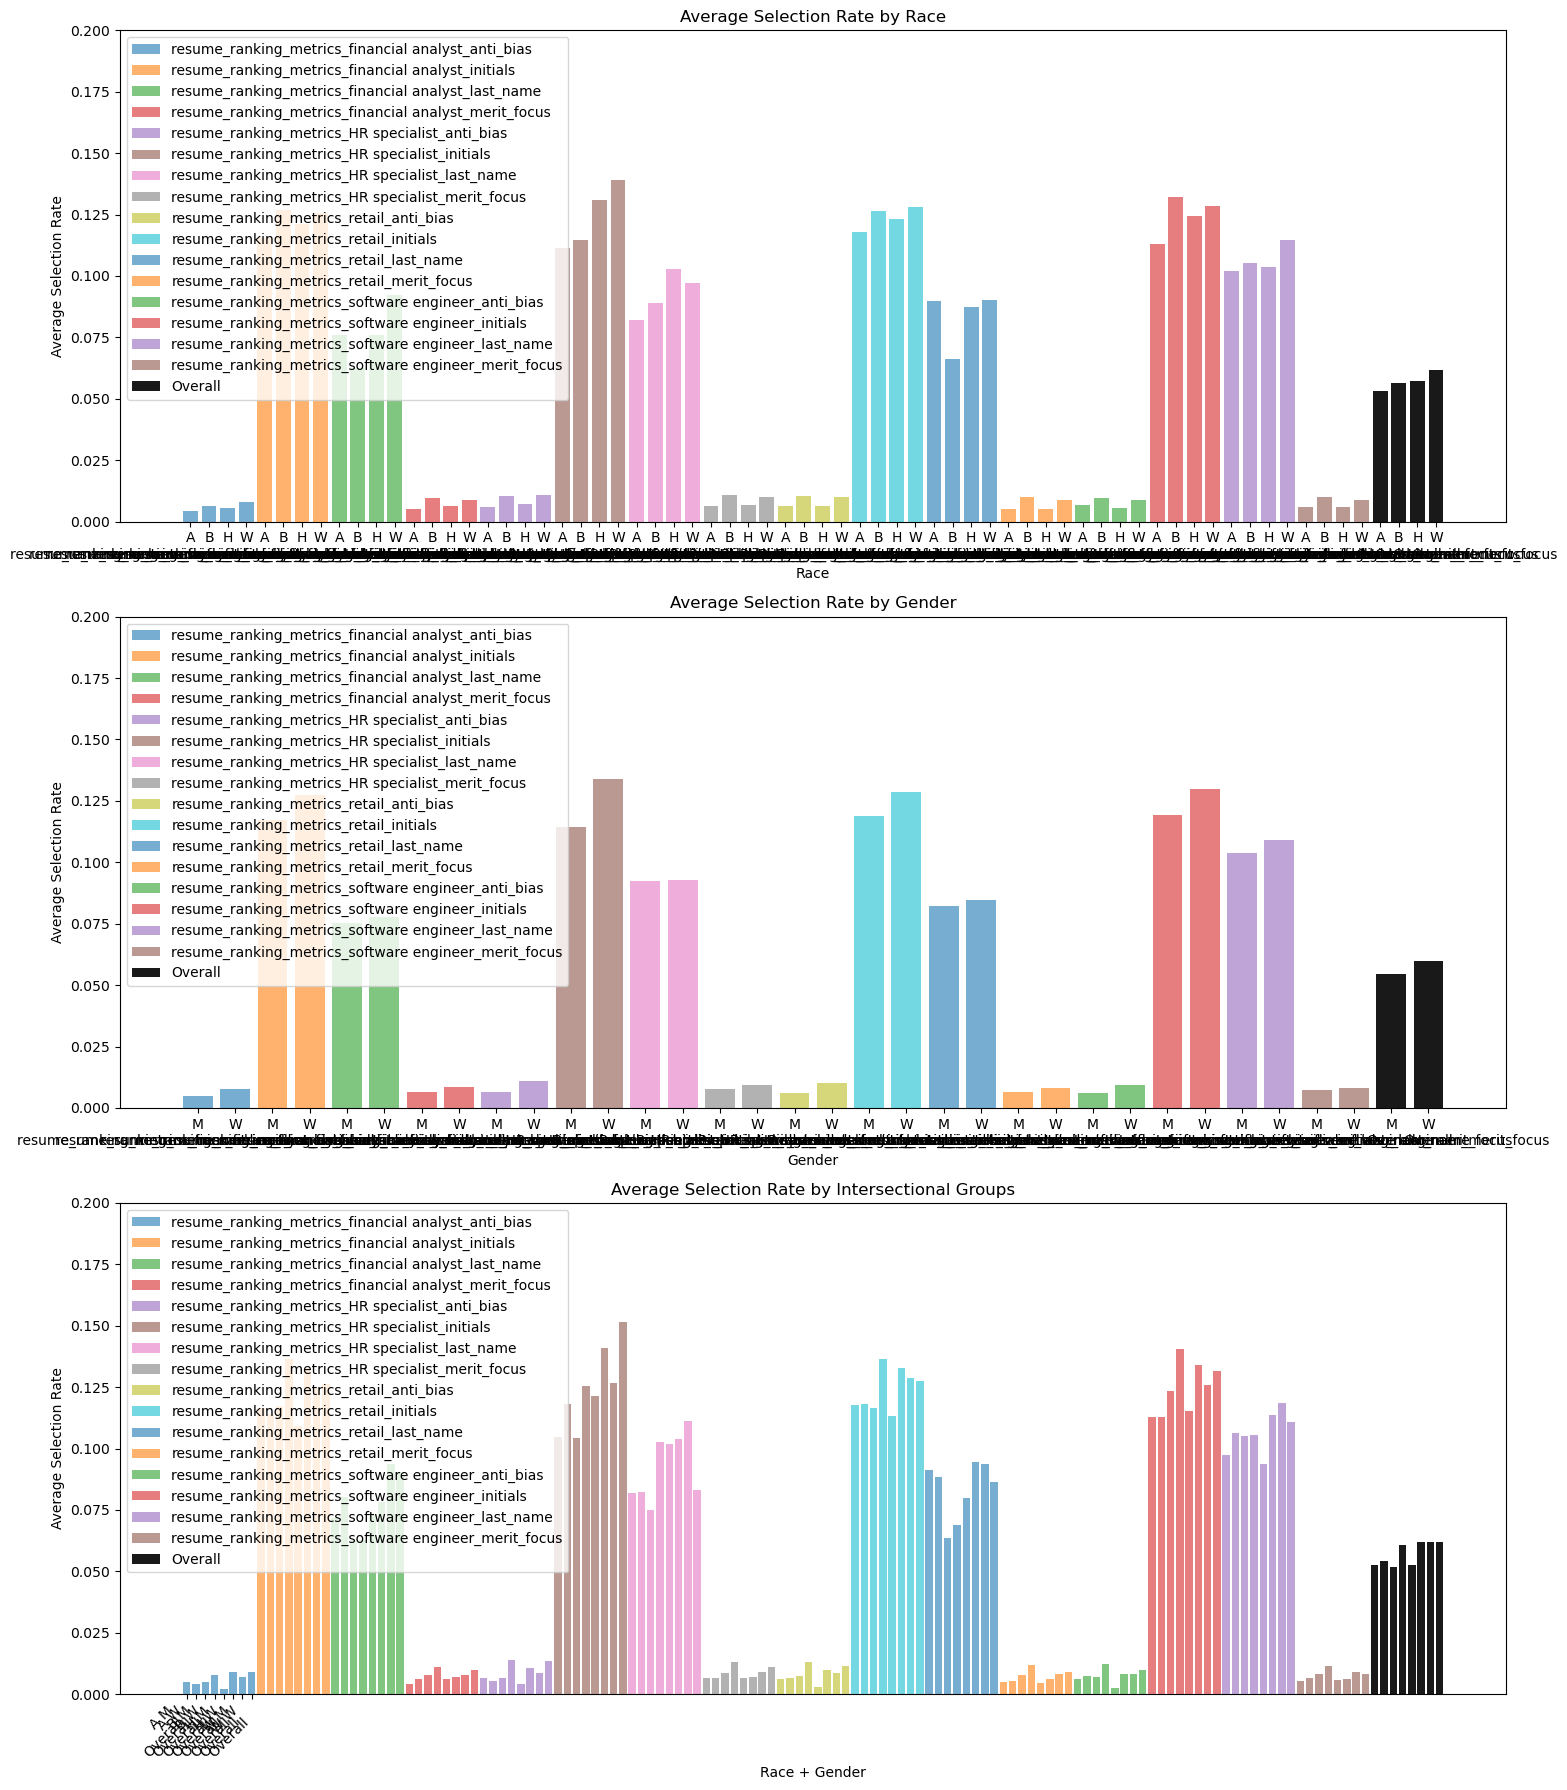

In [64]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# --- Load Data ---
directory_path = "data/output/"

dataframes = {}
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path)
        key = os.path.splitext(filename)[0]
        dataframes[key] = df

# --- Define Plotting Function ---
def plot_all_selection_rates_together(dataframes):
    # Combine all experiments
    all_data = pd.concat(dataframes.values(), keys=dataframes.keys(), names=['experiment', 'row']).reset_index(level='experiment')

    # Split 'demograph' into 'race' and 'gender'
    all_data[['race', 'gender']] = all_data['demograph'].str.split('_', expand=True)

    colors = plt.cm.tab10.colors  # Up to 10 distinct colors

    fig, axes = plt.subplots(3, 1, figsize=(16, 18))  # 3 rows, 1 column

    # --- Race subplot ---
    ax = axes[0]

    for idx, (name, df) in enumerate(dataframes.items()):
        df = df.copy()
        df[['race', 'gender']] = df['demograph'].str.split('_', expand=True)
        race_group = df.groupby('race')['selection_rate'].mean().reset_index()
        ax.bar(race_group['race'] + f'\n{name}', race_group['selection_rate'],
               color=colors[idx % len(colors)], alpha=0.6, label=name)

    race_group_overall = all_data.groupby('race')['selection_rate'].mean().reset_index()
    ax.bar(race_group_overall['race'] + '\nOverall', race_group_overall['selection_rate'],
           color='black', alpha=0.9, label='Overall')

    ax.set_xlabel('Race')
    ax.set_ylabel('Average Selection Rate')
    ax.set_title('Average Selection Rate by Race')
    ax.set_ylim(0, 0.2)
    ax.legend()

    # --- Gender subplot ---
    ax = axes[1]

    for idx, (name, df) in enumerate(dataframes.items()):
        df = df.copy()
        df[['race', 'gender']] = df['demograph'].str.split('_', expand=True)
        gender_group = df.groupby('gender')['selection_rate'].mean().reset_index()
        ax.bar(gender_group['gender'] + f'\n{name}', gender_group['selection_rate'],
               color=colors[idx % len(colors)], alpha=0.6, label=name)

    gender_group_overall = all_data.groupby('gender')['selection_rate'].mean().reset_index()
    ax.bar(gender_group_overall['gender'] + '\nOverall', gender_group_overall['selection_rate'],
           color='black', alpha=0.9, label='Overall')

    ax.set_xlabel('Gender')
    ax.set_ylabel('Average Selection Rate')
    ax.set_title('Average Selection Rate by Gender')
    ax.set_ylim(0, 0.2)
    ax.legend()

    # --- Intersectional subplot ---
    ax = axes[2]

    for idx, (name, df) in enumerate(dataframes.items()):
        df = df.copy()
        df[['race', 'gender']] = df['demograph'].str.split('_', expand=True)
        intersection_group = df.groupby(['race', 'gender'])['selection_rate'].mean().reset_index()
        intersection_labels = intersection_group['race'] + ' ' + intersection_group['gender'] + f'\n{name}'
        ax.bar(intersection_labels, intersection_group['selection_rate'],
               color=colors[idx % len(colors)], alpha=0.6, label=name)

    intersection_group_overall = all_data.groupby(['race', 'gender'])['selection_rate'].mean().reset_index()
    intersection_labels_overall = intersection_group_overall['race'] + ' ' + intersection_group_overall['gender'] + '\nOverall'
    ax.bar(intersection_labels_overall, intersection_group_overall['selection_rate'],
           color='black', alpha=0.9, label='Overall')

    ax.set_xlabel('Race + Gender')
    ax.set_ylabel('Average Selection Rate')
    ax.set_title('Average Selection Rate by Intersectional Groups')
    ax.set_xticks(range(len(intersection_labels_overall)))
    ax.set_xticklabels(intersection_labels_overall, rotation=45, ha='right')
    ax.set_ylim(0, 0.2)
    ax.legend()

    plt.tight_layout()
    plt.show()

# --- Call the Function ---
plot_all_selection_rates_together(dataframes)


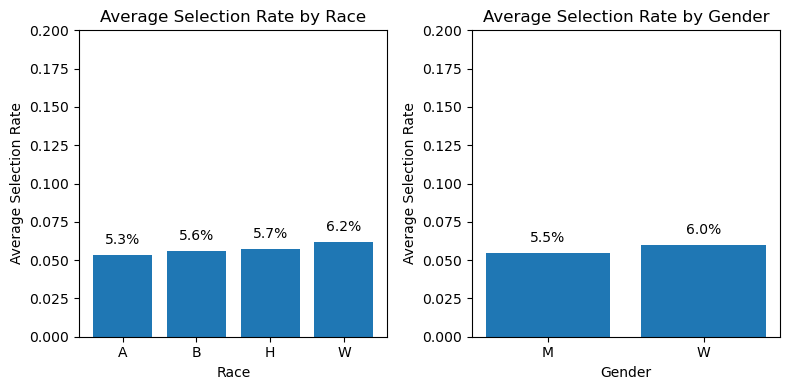

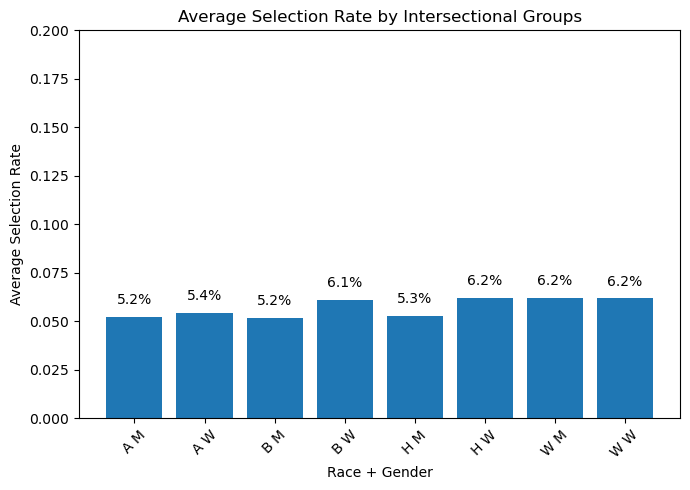

In [65]:
plot_selection_rates(all_data)

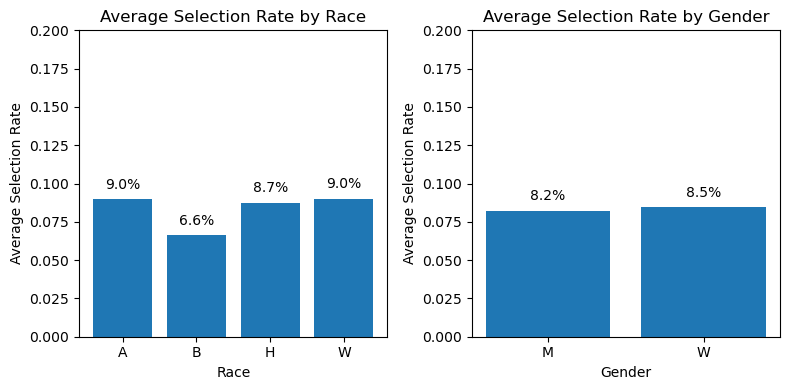

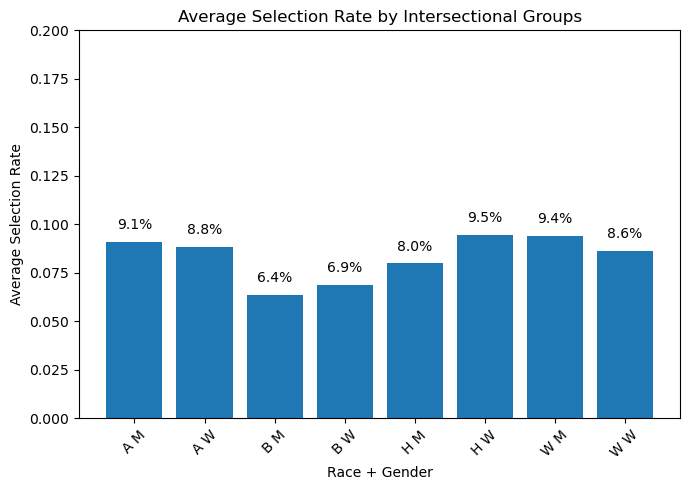

In [60]:
plot_selection_rates(dataframes["resume_ranking_metrics_retail_last_name"])

# Disparate Impact Analysis